## Load the matplotlib magic and the normal pandas stack

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot
import os
import re

## here we'll set the matplotlib figure size to take up more real estate
pyplot.rcParams['figure.figsize'] = [12, 5]

## Read the data into a set of DataFrames

In [8]:
outputFiles = os.listdir('./output')
output_series = (list(), list())
output_metrics = (list(), list())
inputs = (list(), list())
for outputFile in outputFiles:
    simName = outputFile[:outputFile.index('.output')]
    with open("./output/" + outputFile, 'r') as f:
        for cnt, line in enumerate(f):
            split = line.split()
            if len(split) > 1:
                if split[0].startswith('OUT'):
                    measure = split[0][:split[0].rfind('_')]
                    iteration = int(split[0][split[0].rfind('_')+1:])
                    if len(split) > 2:
                        output_series[0].append((simName, measure, iteration))
                        output_series[1].append(pd.Series(split[1:]).astype(float))
                    else:
                        output_metrics[0].append((simName, measure, iteration))
                        output_metrics[1].append(float(split[1]))
                        
                if split[0].startswith('INP'):
                    inputs[0].append((simName, split[0]))
                    inputs[1].append(float(split[1]))
                                   
series_index = pd.MultiIndex.from_tuples(output_series[0], names=['simulation', 'measure', 'iteration'])
series = pd.DataFrame(pd.Series(output_series[1], index=series_index), columns=['values'])

metrics_index = pd.MultiIndex.from_tuples(output_metrics[0], names=['simulation', 'measure', 'iteration'])
metrics = pd.DataFrame(pd.Series(output_metrics[1], index=metrics_index), columns=['values'])

inputs_index = pd.MultiIndex.from_tuples(inputs[0], names=['simulation', 'measure'])
inputs = pd.DataFrame(pd.Series(inputs[1], index=inputs_index), columns=['values'])


## Great, lets take a look at the data! We'll look at the 1000 customer / 10 cashier scenario and create a histogram of the customer shop times.

count    1000.000000
mean       10.538207
std         8.292894
min         2.011400
25%         4.348350
50%         7.997150
75%        13.813400
max        54.025900
dtype: float64

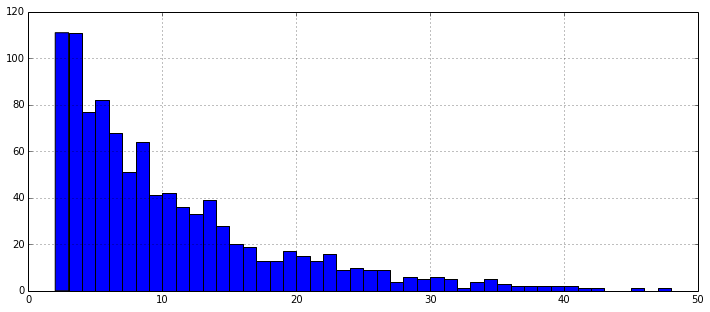

In [9]:
shopTimes = series['values']['cashier_1000_10']['OUT_CUSTOMER_SHOP_TIMES'][0]
_, division = np.histogram(shopTimes, range(int(shopTimes.min()),int(shopTimes.max()),1))
shopTimes.hist(bins=division)
shopTimes.describe()

## We can see it is a lognormal distribution, with a mean of around 15 minutes and a standard deviation of ~8 minutes. That matches up with our input.

## Lets take a look at some entry times.

count    1000.000000
mean      119.752568
std        58.774036
min        22.266000
25%        77.527750
50%       107.474900
75%       147.398025
max       512.871300
dtype: float64

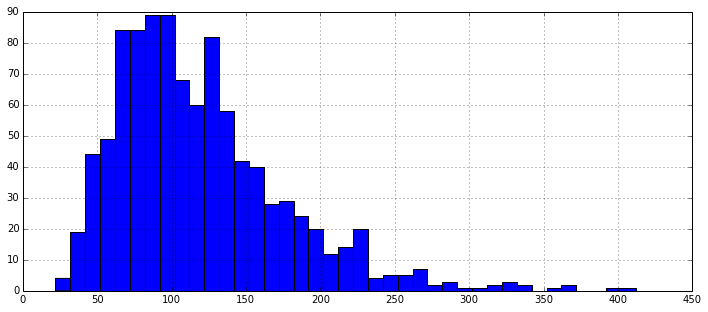

In [10]:
entryTimes = series['values']['cashier_1000_10']['OUT_CUSTOMER_ENTRY_TIMES'][0]
count, division = np.histogram(entryTimes, range(int(entryTimes.min()),int(entryTimes.max()),10))
entryTimes.hist(bins=division)
entryTimes.describe()

## Again, a lognormal distribution. A mean of 120 minutes with a standard deviation of ~ an hour. So far, so good. Lets take a look at the customer wait times

In [11]:
series['values']['cashier_1000_10']['OUT_CUSTOMER_WAIT_TIMES'].apply(lambda x: x.describe())

,count,mean,std,min,25%,50%,75%,max
iteration,,,,,,,,
9,1000.0,36.837381,24.042133,0.0,12.511825,41.35545,61.376400,67.5160
2,1000.0,40.781106,25.813258,0.0,16.052625,45.20225,65.523175,73.8203
4,1000.0,39.021708,25.669850,0.0,14.626350,41.69490,63.086375,75.1371
5,1000.0,55.421882,34.782008,0.0,23.623225,59.71940,88.945800,102.2726
6,1000.0,15.075314,11.356403,0.0,2.650175,15.15200,26.357375,31.1174
3,1000.0,23.199024,16.391236,0.0,6.812200,23.52180,39.558375,45.5785
1,1000.0,21.265424,13.959399,0.0,7.631825,22.97315,35.337675,40.3137
0,1000.0,50.145699,31.013022,0.0,20.799375,57.17685,79.147375,91.5860
8,1000.0,23.546296,16.419651,0.0,7.441150,24.78015,38.943100,47.4195


## Wow, look at those wait times. There is only one iteration that has a mean wait time < 20 minutes. 
---
## Lets broaden our view. We'll count the iterations for each simulation that has a mean wait time of < 15 minutes.

In [12]:
series = series.reset_index()
series.set_index(['measure', 'simulation', 'iteration'], inplace=True)
df = pd.DataFrame(series['values']['OUT_CUSTOMER_WAIT_TIMES'].apply(lambda x: x.mean()))
df.loc[df['values'] < 15].groupby(['simulation']).count()

,values
simulation,
cashier_1000_11,2
cashier_1000_12,9
cashier_1000_13,10
cashier_1000_14,7
cashier_1000_15,10
cashier_1000_16,10
cashier_1000_17,10


## This gives us a good idea of where to start. Lets look at simulations of 12-15 cashiers, but this time, we'll run 90 days worth of iterations.